# ClipedActorCriticNetの制度検証

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install gputil
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 25.9 GB  | Proc size: 95.1 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [3]:
%cd /content/drive/MyDrive/knowledge/deep_reinforcement_learning/actor_critic/

/content/drive/MyDrive/knowledge/deep_reinforcement_learning/actor_critic


In [4]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.8.0
    Uninstalling torch-1.8.0:
      Successfully uninstalled torch-1.8.0


In [2]:
from pathlib import Path
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gym
from gym.wrappers import RecordVideo
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from continuous.agents import ActorCriticModel, ActorClipedCriticModel
from continuous.memories import ReplayMemory

In [3]:
%load_ext autoreload
%autoreload 2

## パラメータの設定

In [4]:
gym_game_name = 'Pendulum-v1'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
result_dir_path = Path('result')
model_dir_path = Path('model')
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

## モデルの精度検証

In [21]:
def train_agent(env, args, device, flag_cliped=0, epochs=300):

    if flag_cliped == 1:
        agent = ActorClipedCriticModel(
            state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0], action_scale=env.action_space.high[0],
            args=args, device=device
        )
    else:
        agent = ActorCriticModel(
            state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0], action_scale=env.action_space.high[0],
            args=args, device=device
        )

    memory = ReplayMemory(args['memory_size'])

    episode_reward_list = []
    eval_reward_list = []

    n_steps = 0
    n_update = 0
    for i_episode in range(1, epochs + 1):

        episode_reward = 0
        done = False
        state = env.reset()

        while not done:
            
            if args['start_steps'] > n_steps:
                action = env.action_space.sample()
            else:
                action = agent.select_action(state)

            if len(memory) > args['batch_size']:
                agent.update_parameters(memory, args['batch_size'], n_update)
                n_update += 1

            next_state, reward, done, _ = env.step(action)
            n_steps += 1
            episode_reward += reward

            memory.push(state=state, action=action, reward=reward, next_state=next_state, mask=float(not done))

            state = next_state

        episode_reward_list.append(episode_reward)

        if i_episode % args['eval_interval'] == 0:
            avg_reward = 0.
            for _  in range(args['eval_interval']):
                state = env.reset()
                episode_reward = 0
                done = False
                while not done:
                    with torch.no_grad():
                        action = agent.select_action(state, evaluate=True)
                    next_state, reward, done, _ = env.step(action)
                    episode_reward += reward
                    state = next_state
                avg_reward += episode_reward
            avg_reward /= args['eval_interval']
            eval_reward_list.append(avg_reward)

    return eval_reward_list, agent

In [12]:
args = {
    'gamma': 0.99,
    'tau': 0.005,
    'alpha': 0.2,
    'seed': 123456,
    'batch_size': 256,
    'hiden_dim': 256,
    'start_steps': 1000,
    'target_update_interval': 1,
    'memory_size': 100000,
    'epochs': 100,
    'eval_interval': 10
}

In [10]:
env = gym.make(gym_game_name)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [24]:
n_experiment = 10
epochs = 300
results = pd.DataFrame()
for flag_cliped in [0, 1]:
    for i in range(1, n_experiment + 1):
        start_time = time.time()
        eval_reward_list, agent = train_agent(
            env=env, args=args, device=device, flag_cliped=flag_cliped, epochs=epochs
        )
        results = pd.concat([
            results,
            pd.DataFrame({
                'agent_type': ['actor_cliped_critic' if flag_cliped == 1 else 'actor_ciric'] * len(eval_reward_list),
                'loop': [i] * len(eval_reward_list),
                'n_step': np.arange(1, len(eval_reward_list) + 1),
                'reward': eval_reward_list
            })
        ], axis=0)
        elapsed_time = time.time() - start_time
        print('[Done] Agent Model: {}, Num Experiment: {}, Time: {:.0f}s'.format(
            'ActorClipedCritic' if flag_cliped == 1 else 'ActorCritic', i, elapsed_time
        ))
        torch.save(agent.actor_net.to('cpu').state_dict(), model_dir_path.joinpath(f'{gym_game_name}_actor_{flag_cliped}_{i}.pth'))
results.to_csv(result_dir_path.joinpath(f'{gym_game_name}_critic_vs_cliped_critic.csv'), index=False)

[Done] Agent Model: ActorCritic, Num Experiment: 1, Time: 431s
[Done] Agent Model: ActorCritic, Num Experiment: 2, Time: 431s
[Done] Agent Model: ActorCritic, Num Experiment: 3, Time: 432s
[Done] Agent Model: ActorCritic, Num Experiment: 4, Time: 431s
[Done] Agent Model: ActorCritic, Num Experiment: 5, Time: 432s
[Done] Agent Model: ActorCritic, Num Experiment: 6, Time: 433s
[Done] Agent Model: ActorCritic, Num Experiment: 7, Time: 429s
[Done] Agent Model: ActorCritic, Num Experiment: 8, Time: 433s
[Done] Agent Model: ActorCritic, Num Experiment: 9, Time: 431s
[Done] Agent Model: ActorCritic, Num Experiment: 10, Time: 431s
[Done] Agent Model: ActorClipedCritic, Num Experiment: 1, Time: 524s
[Done] Agent Model: ActorClipedCritic, Num Experiment: 2, Time: 525s
[Done] Agent Model: ActorClipedCritic, Num Experiment: 3, Time: 522s
[Done] Agent Model: ActorClipedCritic, Num Experiment: 4, Time: 523s
[Done] Agent Model: ActorClipedCritic, Num Experiment: 5, Time: 526s
[Done] Agent Model: Acto

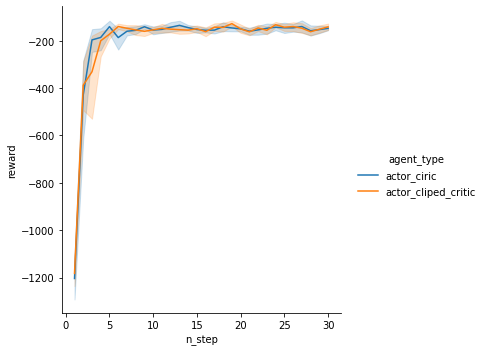

In [26]:
g = sns.relplot(data=results, x='n_step', y='reward', hue='agent_type', kind='line')
g.tight_layout()
g.savefig(result_dir_path.joinpath(f'{gym_game_name}_plot_critic_vs_cliped_critic.png'), dpi=500)

In [8]:
from continuous.models import ActorNet

In [7]:
flag_cliped = 1
i = 1
model_file_path = model_dir_path.joinpath(f'{gym_game_name}_actor_{flag_cliped}_{i}.pth')

In [14]:
actor_net = ActorNet(
    input_dim=env.observation_space.shape[0], output_dim=env.action_space.shape[0],
    hidden_dim=args['hiden_dim'], action_scale=env.action_space.high[0]
).to(device)


<All keys matched successfully>

In [23]:
results = []
for flag_cliped in [0, 1]:
    for model_num in range(1, n_experiment + 1):
        model_file_path = model_dir_path.joinpath(f'{gym_game_name}_actor_{flag_cliped}_{model_num}.pth')
        for loop_num in range(100):
            actor_net.load_state_dict(torch.load(model_file_path))
            state = env.reset()
            episode_reward = 0
            done = False
            while not done:
                state = torch.FloatTensor(state).unsqueeze(0).to(device)
                with torch.no_grad():
                    _, action = actor_net.sample(state)
                    action = action.cpu().detach().numpy().reshape(-1)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                state = next_state
            results.append([flag_cliped, model_num, loop_num, episode_reward])

results = pd.DataFrame(results, columns=['flag_cliped', 'model_num', 'loop_num', 'episode_reward'])

In [32]:
plot_data = results.groupby(['flag_cliped', 'model_num'])['episode_reward'].mean().reset_index()

In [33]:
plot_data

,flag_cliped,model_num,episode_reward
0,0,1,-144.673677
1,0,2,-149.239923
2,0,3,-139.413943
3,0,4,-148.242304
4,0,5,-149.333123
5,0,6,-150.841041
6,0,7,-163.828410
7,0,8,-147.731664
8,0,9,-145.335312
9,0,10,-147.445916


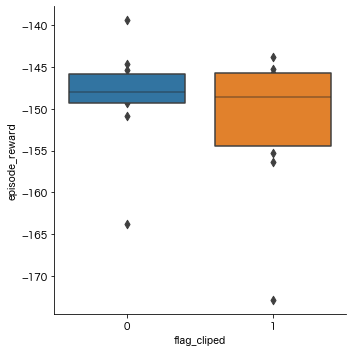

In [35]:
sns.catplot(data=plot_data, x='flag_cliped', y='episode_reward', kind='boxen')